In [1]:
import tensorflow as tf
#--------------------------------------
print(tf.__version__)
import random
random.seed(43)


print(tf.config.list_physical_devices('GPU'))
from tensorflow.compat.v1.keras import backend as K
config =  tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = .5
config.gpu_options.allow_growth = True
sess =  tf.compat.v1.Session(config=config)
K.set_session(sess)
tf.compat.v1.reset_default_graph()
from PIL import Image


2.3.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
import numpy as np 
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
dataset_folder_name = 'UTKFace'
TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 299
dataset_dict = {
    'race_id': {
        0: 'white', 
        1: 'black', 
        2: 'asian', 
        3: 'indian', 
        4: 'others'
    },
    'gender_id': {
        0: 'male',
        1: 'female'
    }
}
dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((r, i) for i, r in dataset_dict['race_id'].items())


In [3]:
def parse_dataset(dataset_path, ext='jpg'):
    """
    Used to extract information about our dataset. It does iterate over all images and return a DataFrame with
    the data (age, gender and sex) of all files.
    """
    def parse_info_from_file(path):
        """
        Parse information from a single file
        """
        try:
            filename = os.path.split(path)[1]
            filename = os.path.splitext(filename)[0]
            age, gender, race, _ = filename.split('_')
            return int(age), dataset_dict['gender_id'][int(gender)], dataset_dict['race_id'][int(race)]
        except Exception as ex:
            return None, None, None
        
    files = glob.glob(os.path.join(dataset_path, "*.%s" % ext))
    
    records = []
    for file in files:
        info = parse_info_from_file(file)
        records.append(info)
        
    df = pd.DataFrame(records)
    df['file'] = files
    df.columns = ['age', 'gender', 'race', 'file']
    df = df.dropna()
    
    return df
df = parse_dataset('../UTKfaceCut')
df.head()

age  gender    race                                        file
0  61.0  female   white  ../UTKfaceCut/61_1_0_20170117192206514.jpg
1  79.0    male   asian  ../UTKfaceCut/79_0_2_20170112223937939.jpg
2  26.0  female  indian  ../UTKfaceCut/26_1_3_20170117174433574.jpg
3  89.0  female   white  ../UTKfaceCut/89_1_0_20170120225533673.jpg
4  26.0  female  indian  ../UTKfaceCut/26_1_3_20170104214236981.jpg

In [11]:
import plotly.graph_objects as go
def plot_distribution(pd_series):
    labels = pd_series.value_counts().index.tolist()
    counts = pd_series.value_counts().values.tolist()
    
    pie_plot = go.Pie(labels=labels, values=counts, hole=.3)
    fig = go.Figure(data=[pie_plot])
    fig.update_layout(title_text='Distribution for %s' % pd_series.name)
    
    fig.show()

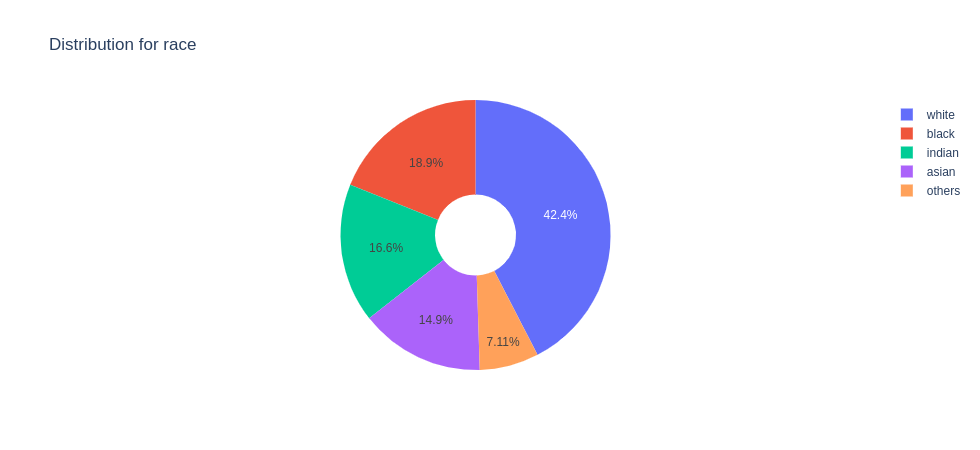

In [5]:
plot_distribution(df['race'])


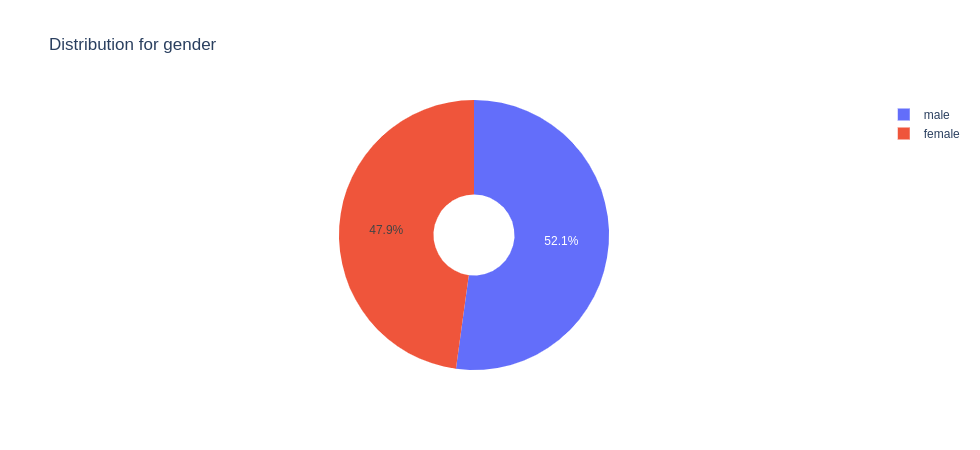

In [6]:
plot_distribution(df['gender'])


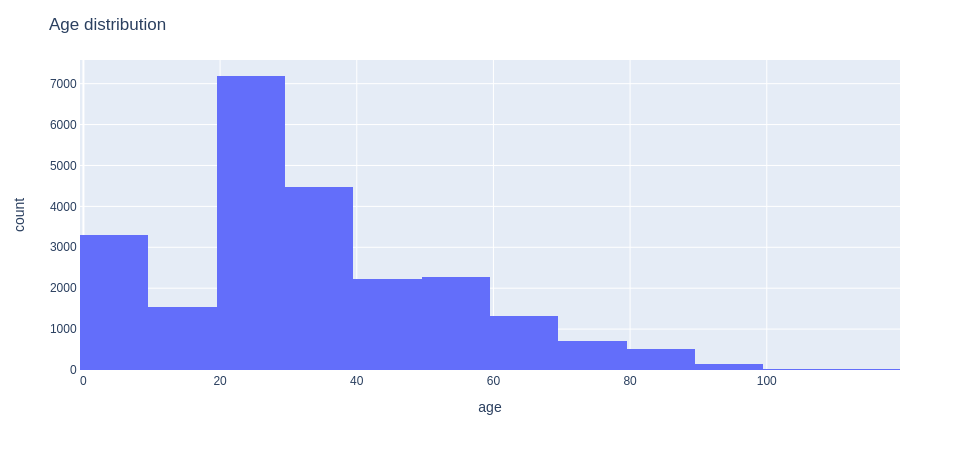

In [7]:
import plotly.express as px
fig = px.histogram(df, x="age", nbins=20)
fig.update_layout(title_text='Age distribution')
fig.show()

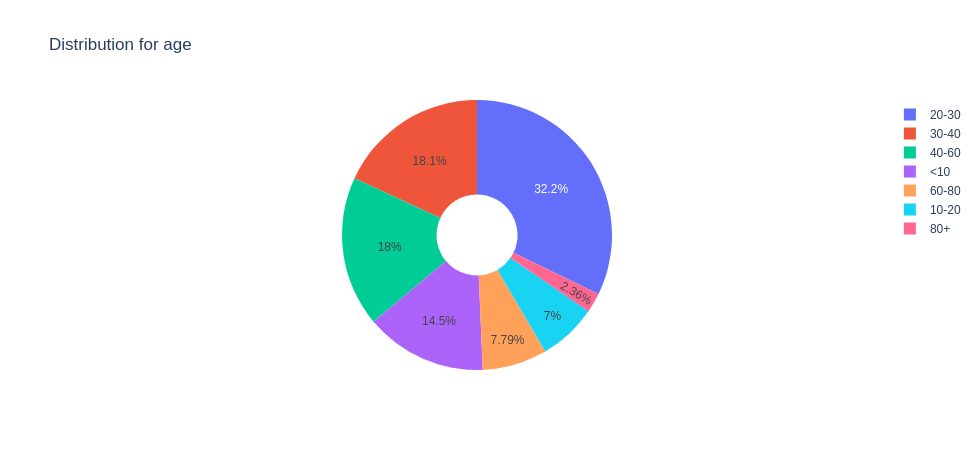

In [8]:
bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
names = ['<10', '10-20', '20-30', '30-40', '40-60', '60-80', '80+']
age_binned = pd.cut(df['age'], bins, labels=names)
plot_distribution(age_binned)

In [4]:
from keras.utils import to_categorical
class UtkFaceDataGenerator():
    """
    Data generator for the UTKFace dataset. This class should be used when training our Keras multi-output model.
    """
    def __init__(self, df):
        self.df = df
        
    def generate_split_indexes(self):
        p = np.random.permutation(len(self.df))
        train_up_to = int(len(self.df) * TRAIN_TEST_SPLIT)
        train_idx = p[:train_up_to]
        test_idx = p[train_up_to:]
        train_up_to = int(train_up_to * TRAIN_TEST_SPLIT)
        train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]
        
        # converts alias to id
        self.df['gender_id'] = self.df['gender'].map(lambda gender: dataset_dict['gender_alias'][gender])
        self.df['race_id'] = self.df['race'].map(lambda race: dataset_dict['race_alias'][race])
        self.max_age = self.df['age'].max()
        
        return train_idx, valid_idx, test_idx
    
    def preprocess_image(self, img_path):
        """
        Used to perform some minor preprocessing on the image before inputting into the network.
        """
        im = Image.open(img_path)
        im = im.resize((IM_WIDTH, IM_HEIGHT))
        im = np.array(im) / 255.0
        
        return im
        
    def generate_images(self, image_idx, is_training, batch_size=16):
        """
        Used to generate a batch with images when training/testing/validating our Keras model.
        """
        
        # arrays to store our batched data
        images, ages, races, genders = [], [], [], []
        while True:
            for idx in image_idx:
                person = self.df.iloc[idx]
                
                age = person['age']
                race = person['race_id']
                gender = person['gender_id']
                file = person['file']
                
                im = self.preprocess_image(file)
                
                ages.append(age / self.max_age)
                races.append(to_categorical(race, len(dataset_dict['race_id'])))
                genders.append(to_categorical(gender, len(dataset_dict['gender_id'])))
                images.append(im)
                
                # yielding condition
                if len(images) >= batch_size:
                    yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                    images, ages, races, genders = [], [], [], []
                    
            if not is_training:
                break
                
data_generator = UtkFaceDataGenerator(df)
train_idx, valid_idx, test_idx = data_generator.generate_split_indexes()

Using TensorFlow backend.


In [10]:

class UtkMultiOutputModel():
    """
    Used to generate our multi-output model. This CNN contains three branches, one for age, other for 
    sex and another for race. Each branch contains a sequence of Convolutional Layers that is defined
    on the make_default_hidden_layers method.
    """
    def make_default_hidden_layers(self, inputs):
        """
        Used to generate a default set of hidden layers. The structure used in this network is defined as:
        
        Conv2D -> BatchNormalization -> Pooling -> Dropout
        """
        

        x = tf.keras.layers.Conv2D(16, (3, 3), padding="same")(inputs)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.BatchNormalization(axis=-1)(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3))(x)
        x = tf.keras.layers.Dropout(0.25)(x)
        x = tf.keras.layers.Conv2D(32, (3, 3), padding="same")(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.BatchNormalization(axis=-1)(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = tf.keras.layers.Dropout(0.25)(x)
        x = tf.keras.layers.Conv2D(32, (3, 3), padding="same")(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.BatchNormalization(axis=-1)(x)
        x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
        x = tf.keras.layers.Dropout(0.25)(x)
        return x
    def build_race_branch(self, inputs, num_races):
        """
        Used to build the race branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = self.make_default_hidden_layers(inputs)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(128)(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.Dense(num_races)(x)
        x = tf.keras.layers.Activation("softmax", name="race_output")(x)
        return x
    def build_gender_branch(self, inputs, num_genders=2):
        """
        Used to build the gender branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = tf.keras.layers.Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)
        x = self.make_default_hidden_layers(inputs)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(128)(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.Dense(num_genders)(x)
        x = tf.keras.layers.Activation("sigmoid", name="gender_output")(x)
        return x
    def build_age_branch(self, inputs):   
        """
        Used to build the age branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = self.make_default_hidden_layers(inputs)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(128)(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.Dense(1)(x)
        x = tf.keras.layers.Activation("linear", name="age_output")(x)
        return x
    def assemble_full_model(self, width, height, num_races):
        """
        Used to assemble our multi-output model CNN.
        """
        input_shape = (height, width, 3)
        inputs =  tf.keras.Input(shape=input_shape)
        age_branch = self.build_age_branch(inputs)
        race_branch = self.build_race_branch(inputs, num_races)
        gender_branch = self.build_gender_branch(inputs)
        model = tf.keras.models.Model(inputs=inputs,
                     outputs = [age_branch, race_branch, gender_branch],
                     name="face_net")
        return model
    
model = UtkMultiOutputModel().assemble_full_model(IM_WIDTH, IM_HEIGHT, num_races=len(dataset_dict['race_alias']))

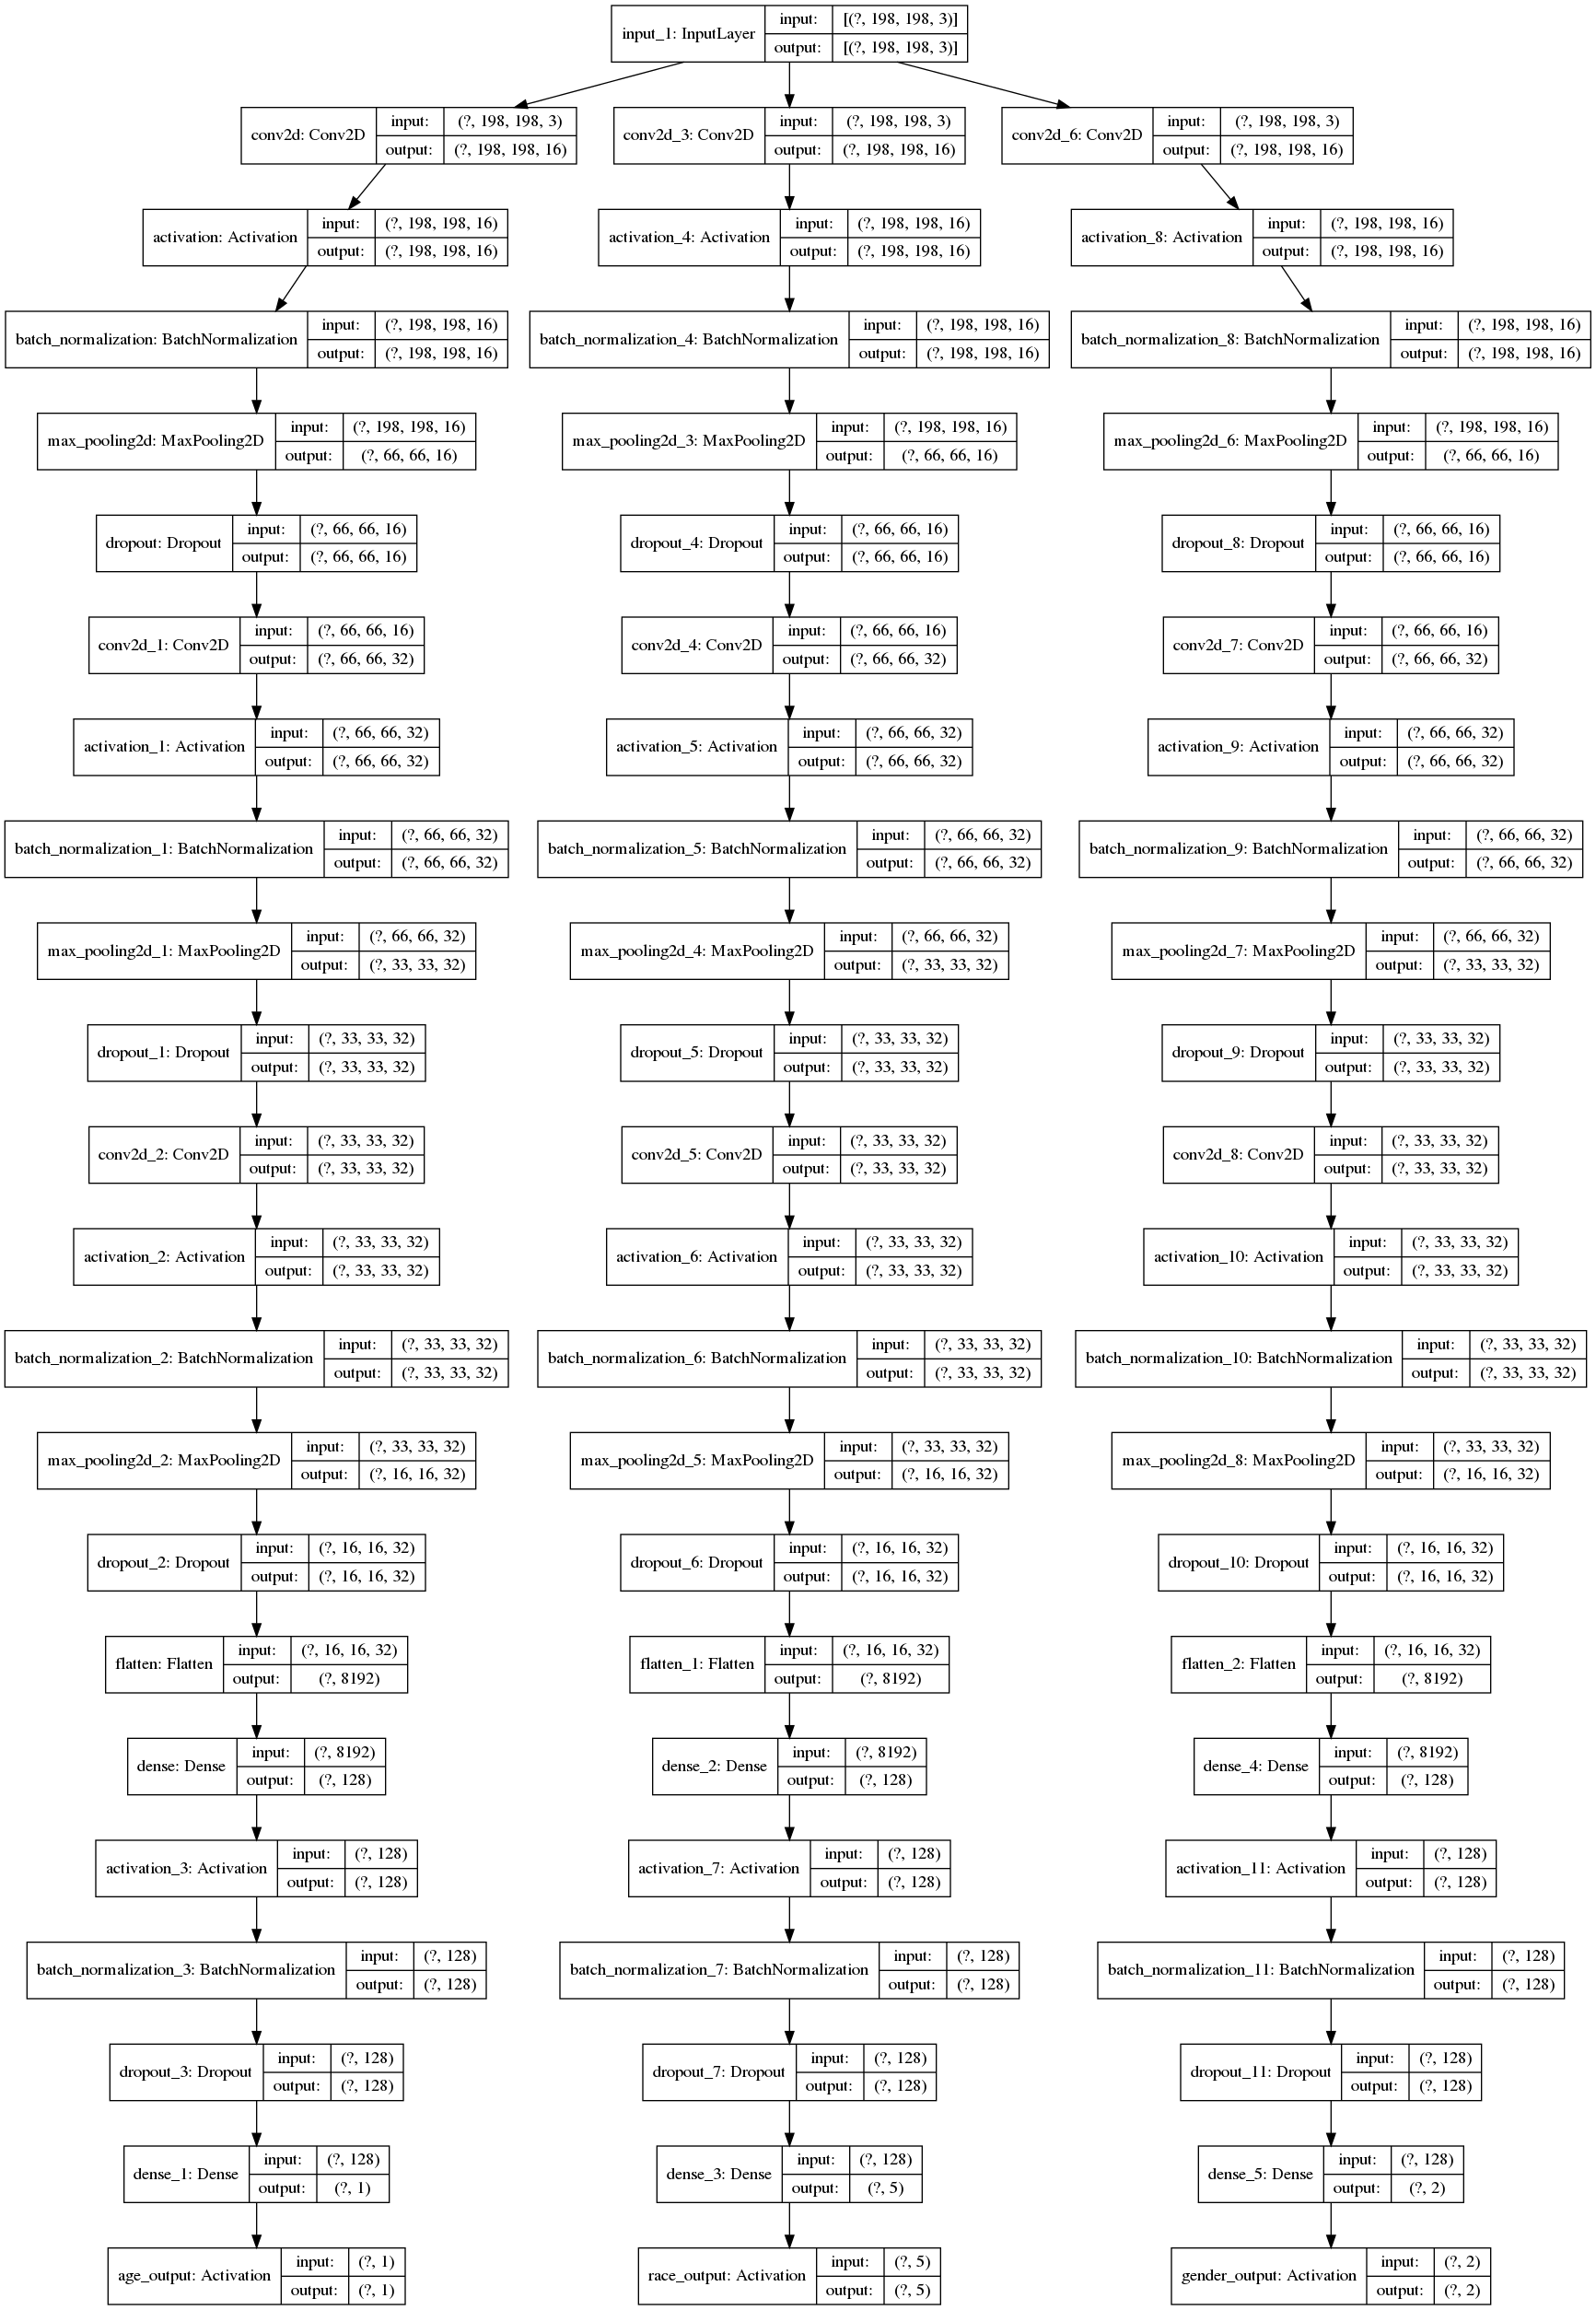

In [11]:
tf.keras.utils.plot_model(model,to_file="model2.png",
    show_shapes=True,show_layer_names=True,rankdir="TB",expand_nested=False,dpi=96)

Tensor("resnet50/conv_7b_ac/Relu:0", shape=(None, 8, 8, 1536), dtype=float32)


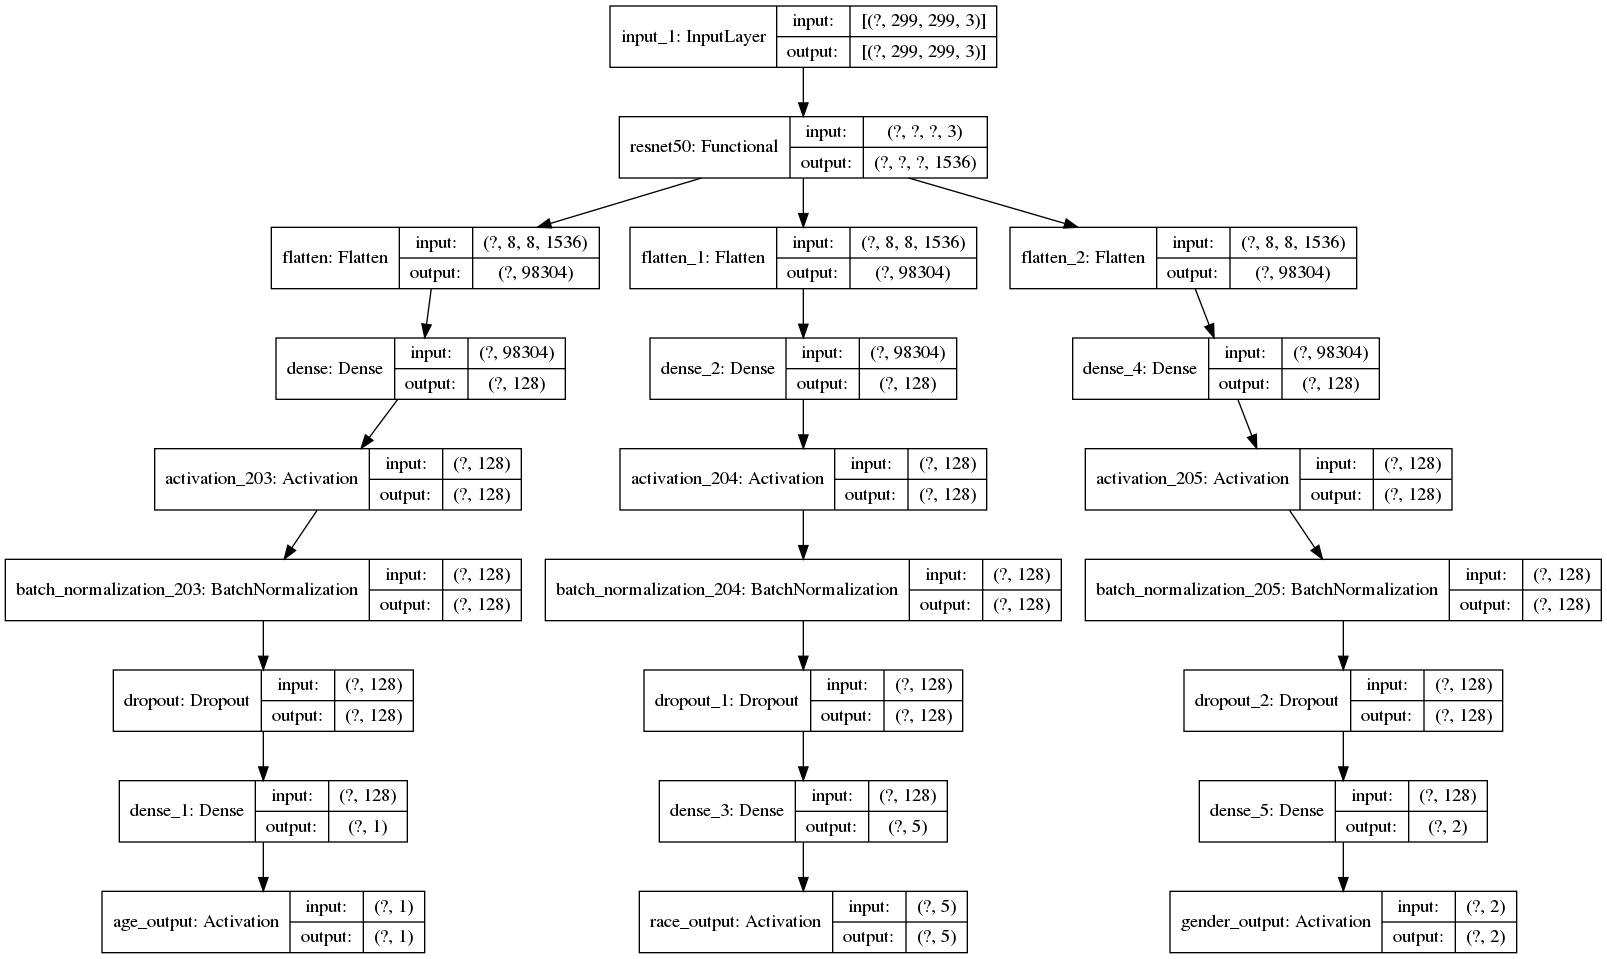

In [5]:
class UtkMultiOutputModel():
    """
    Used to generate our multi-output model. This CNN contains three branches, one for age, other for 
    sex and another for race. Each branch contains a sequence of Convolutional Layers that is defined
    on the make_default_hidden_layers method.
    """
    def make_default_hidden_layers(self, inputs,name='resnet50_1'):
        """
        Used to generate a default set of hidden layers. The structure used in this network is defined as:
        
        Conv2D -> BatchNormalization -> Pooling -> Dropout
        """
        
        base_model=tf.keras.applications.InceptionResNetV2(include_top=False, weights='imagenet')
#         base_model.trainable = False
#         x = base_model(inputs, training=False)

        res_net = tf.keras.models.Model(inputs=base_model.input, outputs=base_model.output, name=name)
        x = res_net(inputs)

        print(x)

        return x
    def build_race_branch(self, x, num_races):
        """
        Used to build the race branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(128)(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.Dense(num_races)(x)
        x = tf.keras.layers.Activation("softmax", name="race_output")(x)
        return x
    def build_gender_branch(self, x, num_genders=2):
        """
        Used to build the gender branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
       
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(128)(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.Dense(num_genders)(x)
        x = tf.keras.layers.Activation("sigmoid", name="gender_output")(x)
        return x
    def build_age_branch(self, x):   
        """
        Used to build the age branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(128)(x)
        x = tf.keras.layers.Activation("relu")(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.Dense(1)(x)
        x = tf.keras.layers.Activation("linear", name="age_output")(x)
        return x
    def assemble_full_model(self, width, height, num_races):
        """
        Used to assemble our multi-output model CNN.
        """
        input_shape = (height, width, 3)
        inputs =  tf.keras.Input(shape=input_shape)
        x = self.make_default_hidden_layers(inputs,name='resnet50')
        age_branch = self.build_age_branch(x)
        race_branch = self.build_race_branch(x, num_races)
        gender_branch = self.build_gender_branch(x)
        model = tf.keras.models.Model(inputs=inputs,
                     outputs = [age_branch, race_branch, gender_branch],
                     name="face_net")
        return model
    
model = UtkMultiOutputModel().assemble_full_model(IM_WIDTH, IM_HEIGHT, num_races=len(dataset_dict['race_alias']))


tf.keras.utils.plot_model(model,to_file="model3.png",
    show_shapes=True,show_layer_names=True,rankdir="TB",expand_nested=False,dpi=96)

In [10]:
from tensorflow.keras.optimizers import Adam
from focal_loss import SparseCategoricalFocalLoss
from focal_loss import BinaryFocalLoss
init_lr = 1e-4
epochs = 100
opt = Adam(lr=init_lr, decay=init_lr / epochs)
model.compile(optimizer=opt, 
              
              loss={
                  'age_output': 'mse', 
                  'race_output': 'categorical_crossentropy', 
                  'gender_output': 'binary_crossentropy'},
              loss_weights={
                  'age_output': 4., 
                  'race_output': 1.5, 
                  'gender_output': 0.1},
              metrics={
                  'age_output': 'mae', 
                  'race_output': 'accuracy',
                  'gender_output': 'accuracy'})

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint
batch_size = 16
valid_batch_size = 16
train_gen = data_generator.generate_images(train_idx, is_training=True, batch_size=batch_size)
valid_gen = data_generator.generate_images(valid_idx, is_training=True, batch_size=valid_batch_size)
callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]
history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)


Epoch 1/100
725/725 [==============================] - ETA: 0s - loss: 11.7310 - age_output_loss: 2.2199 - race_output_loss: 1.8580 - gender_output_loss: 0.6425 - age_output_mae: 1.1559 - race_output_accuracy: 0.4061 - gender_output_accuracy: 0.7335WARNING:tensorflow:From /home/ai/.local/lib/python3.6/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./model_checkpoint/assets
725/725 [==============================] - 284s 392ms/step - loss: 11.7310 - age_output_loss: 2.2199 - race_output_loss: 1.8580 - gender_output_loss: 0.6425 - age_output_mae: 1.1559 - race_output_accuracy: 0.4061 

KeyboardInterrupt: 

In [7]:
print("weights:", len(model.weights))
print("trainable_weights:", len(model.trainable_weights))
print("non_trainable_weights:", len(model.non_trainable_weights))

weights: 920
trainable_weights: 506
non_trainable_weights: 414


In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint
batch_size = 16
valid_batch_size = 16
train_gen = data_generator.generate_images(train_idx, is_training=True, batch_size=batch_size)
valid_gen = data_generator.generate_images(valid_idx, is_training=True, batch_size=valid_batch_size)
callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]
history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

Epoch 1/100
725/725 [==============================] - ETA: 0s - loss: 6.8748 - age_output_loss: 1.1867 - race_output_loss: 1.3879 - gender_output_loss: 0.4614 - age_output_mae: 0.7918 - race_output_accuracy: 0.5179 - gender_output_accuracy: 0.8009WARNING:tensorflow:From /home/ai/.local/lib/python3.6/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ./model_checkpoint/assets
725/725 [==============================] - 321s 443ms/step - loss: 6.8748 - age_output_loss: 1.1867 - race_output_loss: 1.3879 - gender_output_loss: 0.4614 - age_output_mae: 0.7918 - race_output_accuracy: 0.5179 - 

KeyboardInterrupt: 

In [13]:
import plotly.graph_objects as go

plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['race_output_acc'],
                    name='Train'))
fig.add_trace(go.Scatter(
                    y=history.history['val_race_output_acc'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy for race feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

NameError: name 'history' is not defined

<Figure size 432x288 with 0 Axes>

In [14]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['gender_output_acc'],
                    name='Train'))
fig.add_trace(go.Scatter(
                    y=history.history['val_gender_output_acc'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy for gender feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

NameError: name 'history' is not defined

<Figure size 432x288 with 0 Axes>

In [15]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scattergl(
                    y=history.history['age_output_mean_absolute_error'],
                    name='Train'))
fig.add_trace(go.Scattergl(
                    y=history.history['val_age_output_mean_absolute_error'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Mean Absolute Error for age feature',
                  xaxis_title='Epoch',
                  yaxis_title='Mean Absolute Error')
fig.show()

NameError: name 'history' is not defined

<Figure size 432x288 with 0 Axes>